In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import sys, os
from time import time
from pathlib import Path
from itertools import product
from tqdm import tqdm

import numpy as np
import pandas as pd

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, BatchNormalization
from tensorflow.keras.models import Model
from scipy.stats import spearmanr

import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback
from keras.utils import Sequence

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    print("Using GPU")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("Using CPU")
    exit()

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from utils import MultipleTimeSeriesCV, format_time

idx = pd.IndexSlice
sns.set_style("whitegrid")
np.random.seed(42)

results_path = Path("KR2_results", "asset_pricing")
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


In [13]:
scores = []
with pd.HDFStore(results_path / "scores.h5") as store:
    for key in store.keys():
        scores.append(store[key])
scores = pd.concat(scores)

In [14]:
scores

,units,n_factors,fold,epoch,ic_mean,ic_daily_mean,ic_daily_std,ic_daily_median
0,8,2,0,0,0.000191,0.019373,0.097301,0.009099
1,8,2,0,1,-0.012392,0.015854,0.096604,0.009033
2,8,2,0,2,-0.035728,0.013590,0.097544,0.009117
3,8,2,0,3,-0.024633,-0.002630,0.087844,0.011029
4,8,2,0,4,-0.014261,-0.000243,0.074160,0.018685
...,...,...,...,...,...,...,...,...
1245,16,6,4,245,0.028360,0.037812,0.133744,0.051901
1246,16,6,4,246,0.028343,0.037746,0.133536,0.052023
1247,16,6,4,247,0.028374,0.037769,0.133454,0.052250
1248,16,6,4,248,0.028425,0.037839,0.133564,0.052126


In [16]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       [['ic_mean', 'ic_daily_mean', 'ic_daily_median']]
       .mean()
      .reset_index())

top = (
    avg.groupby(["n_factors", "units"])
    .apply(lambda x: x.nlargest(n=5, columns=["ic_daily_median"]))
    .reset_index(-1, drop=True)
)


In [21]:
# 대충 좋은 에포크 찾는 코드
avg.nlargest(n=50, columns=["ic_daily_median"])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
3216,6,8,216,0.010062,0.019202,0.028312
3223,6,8,223,0.009806,0.018463,0.026830
3189,6,8,189,0.008489,0.018126,0.026528
503,2,32,3,0.006298,0.015453,0.026208
504,2,32,4,0.006436,0.017420,0.026048
3182,6,8,182,0.012709,0.021526,0.025965
3210,6,8,210,0.010195,0.018623,0.025328
3230,6,8,230,0.010699,0.018829,0.025303
3176,6,8,176,0.015376,0.021481,0.024871
513,2,32,13,0.008345,0.012594,0.024188


In [20]:
top.nlargest(n=5, columns=["ic_daily_median"])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
6         8              6      8    216  0.010062       0.019202   
          8              6      8    223  0.009806       0.018463   
          8              6      8    189  0.008489       0.018126   
2         32             2     32      3  0.006298       0.015453   
          32             2     32      4  0.006436       0.017420   

                 ic_daily_median  
n_factors units                   
6         8             0.028312  
          8             0.026830  
          8             0.026528  
2         32            0.026208  
          32            0.026048

In [22]:
# 대충 좋은 에포크 입력하는 코드
n_factors = 6
units = 8
batch_size = 64 # 256
first_epoch = 180
last_epoch = 210

In [ ]:

predictions = []
for epoch in tqdm(list(range(first_epoch, last_epoch))):
    epoch_preds = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(
            data, train_idx, val_idx
        )

        train_gen = DataGenerator(X1_train, X2_train, y_train, batch_size=batch_size)
        val_gen = DataGenerator(X1_val, X2_val, y_val, batch_size=batch_size)
        model = make_model(hidden_units=units, n_factors=n_factors)
        model.fit_generator(
            train_gen,
            validation_data=val_gen,
            epochs=epoch,
            verbose=0,
            shuffle=True,
            callbacks=[ClearMemory(), early_stop],
        )
        epoch_preds.append(
            pd.Series(
                model.predict_generator(
                    val_gen, callbacks=[ClearMemory(), early_stop]
                ).reshape(-1),
                index=y_val.stack().index,
            ).to_frame(epoch)
        )

    predictions.append(pd.concat(epoch_preds))

predictions_combined = pd.concat(predictions, axis=1).sort_index()
predictions_combined.to_hdf(results_path / "predictions.h5", "predictions")


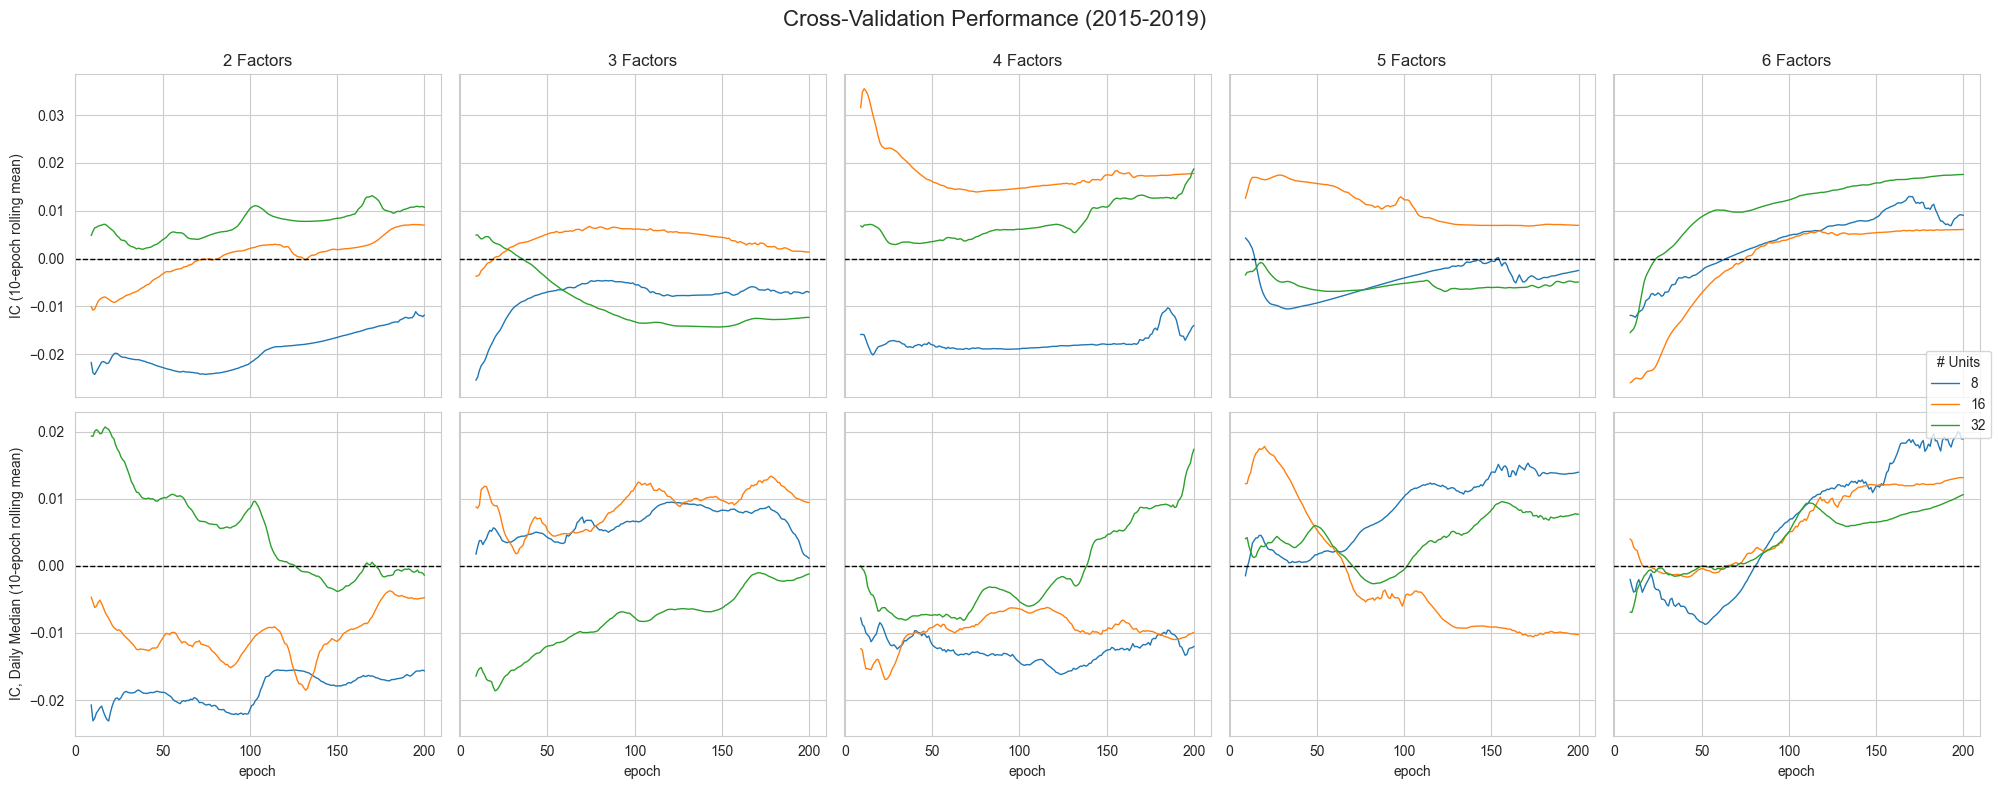

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'cv_performance', dpi=600);